In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import keras_cv
import cv2

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

2024-02-01 13:11:10.907649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 13:11:12.067712: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


In [2]:
(training_set, validation_set), dataset_info = tfds.load('kitti',
                                                         split=['train[:50%]', 'validation'],
                                                        #  download=True,
                                                         with_info=True,
                                                         )
# as_supervised=True
# kitti doesnt support

2024-02-01 13:11:17.034006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:11:17.154865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:11:17.154954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:11:17.157731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-01 13:11:17.157944: I tensorflow/compile

In [ ]:
print(dataset_info)

In [ ]:

tfds.as_dataframe(training_set.take(4), dataset_info)

In [ ]:
fig = tfds.show_examples(training_set, dataset_info)

Test if objects are correctly bounded with boxes.

In [ ]:
# this is shitty, because with each bounding_box_format it is misplaced in y-axis
ds = training_set.take(6)  # Only take n examples

def unpackage_tfds_inputs(inputs):
        image = inputs["image"]
        classes = tf.cast(inputs["objects"]["type"], tf.float32)
        boxes = inputs["objects"]["bbox"]
        bounding_boxes = {"classes": classes, "boxes": boxes}
        return image, bounding_boxes

train_ds = ds.map(unpackage_tfds_inputs)
train_ds = train_ds.apply(tf.data.experimental.dense_to_ragged_batch(16))
images, boxes = next(iter(train_ds.take(1)))

keras_cv.visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="REL_YXYX",
    y_true=boxes,
    scale=10,
    rows=2,
    cols=2,
    line_thickness=4,
    font_scale=1,
)

Correctly placed boxes around detected objects.

In [ ]:
objects = []

ds = training_set.take(6)  # Only take n examples    
for example in ds:
    boxes = example["objects"]["bbox"]
    h,w,ch = example["image"].shape
    image = np.copy(example["image"])
    for box in boxes:
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)
        cv2.rectangle(
                image,
                (xmax, ymax),
                (xmin, ymin),
                (255, 0, 0, 0.5),
                4
            )
    object = tf.image.resize(image, (374, 1238))
    objects.append(object)
    
keras_cv.visualization.plot_image_gallery(
np.array(objects), rows=3, cols=2, value_range=(0, 255), show=True, scale=4)
    

In [3]:
# a method to transform object-detection dataset to classification dataset
def create_classification_dataset(dataset, take_number, shape):
    # sh = 0
    ds = dataset.take(take_number)
    objects = []
    labels = []
    for inputs in ds:
        image = inputs["image"]
        # print(image.shape)   
        boxes = inputs["objects"]["bbox"]
        classes = inputs["objects"]["type"]
        h,w,ch = inputs["image"].shape
        for box, label in zip(boxes, classes):
            # print(box)
            ymin, xmin, ymax, xmax = box
            ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
            object = image[ymax:ymin, xmin:xmax, :]
            # sh = max(sh,max(object.shape[1],object.shape[0]))
            
            if object.shape[1]==0 or object.shape[0]==0:                
                testimage = np.copy(example["image"])
                cv2.rectangle(
                    testimage,
                    (xmax, ymax),
                    (xmin, ymin),
                    (255, 0, 0, 0.5),
                    4
                )
                keras_cv.visualization.plot_image_gallery(
                    np.array([testimage]), rows=1, cols=1, value_range=(0, 255), show=True, scale=4)
            object = tf.image.resize(object, shape)
            objects.append(object)
            # print(object.shape)
            labels.append(label)
    # print(sh)
    # rt=tf.ragged.stack(objects)
    # print(len(objects))  
    # print(objects.shape)      
    # features_dataset = tf.data.Dataset.from_tensor_slices(rt)
    # print(features_dataset)
    # labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    # print(labels_dataset)
    # train_ds = tf.data.Dataset.zip((features_dataset, labels_dataset))
    train_ds = tf.data.Dataset.from_tensor_slices({'image': objects, 'label':labels})
    return train_ds

In [ ]:
train_ds = create_classification_dataset(training_set, 400, (50,50))
print(len(train_ds))
# for example in train_ds:
#     print(example['image'].shape, example['label'])
rows = len(train_ds)//2
# keras_cv.visualization.plot_image_gallery(train_ds, rows=rows, cols=2, value_range=(0, 255), show=True, scale=4)
    

In [4]:
IMAGE_RES = 50

print(len(training_set))
train_ds = create_classification_dataset(training_set, 1000, (IMAGE_RES,IMAGE_RES))
print(len(train_ds))

3174
5449


In [5]:
train_size = int(0.7 * len(train_ds))
val_size = int(0.15 * len(train_ds))
test_size = int(0.15 * len(train_ds))

real_ds = train_ds.shuffle(len(train_ds)//4)
train_dataset = real_ds.take(train_size)
test_dataset = real_ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

# now we have train_dataset, val_dataset and test_dataset

In [6]:
# number of images in datasets
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3814
818
817


In [7]:
for example in test_dataset.take(2):
    print(example['image'].shape, example["label"])
# for image, label in test_dataset.values():
#     print(image.shape, label)

(50, 50, 3) tf.Tensor(2, shape=(), dtype=int64)
(50, 50, 3) tf.Tensor(0, shape=(), dtype=int64)


## Data Augmentation

### Option 1: use the Keras preprocessing layers (You can also create custom data augmentation layers)

__a: Make the preprocessing layers part of your model__

```
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])
```
There are two important points to be aware of in this case:
- Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.
- When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

__b: Apply the preprocessing layers to your dataset__

```
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))
```
With this approach, you use Dataset.map to create a dataset that yields batches of augmented images. In this case:
- Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below.
- In this case the preprocessing layers will not be exported with the model when you call Model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

### Apply random transformations to the images
```
tf.image.stateless_random_brightness
tf.image.stateless_random_contrast
tf.image.stateless_random_crop
tf.image.stateless_random_flip_left_right
tf.image.stateless_random_flip_up_down
tf.image.stateless_random_hue
tf.image.stateless_random_jpeg_quality
tf.image.stateless_random_saturation
```
They require a `seed` value, which is a Tensor of shape (2,) whose values are any integers.

```
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
```

In [11]:
IMAGE_RES = 224

resizer_rescaler = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.Resizing(IMAGE_RES, IMAGE_RES, interpolation="bilinear"),
        keras_cv.layers.Rescaling(scale=1./255., offset=0.0)
    ],
)


augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandAugment(value_range=(0, 255))
    ],
)

def preprocess_data(input, augment=False):
    # labels = tf.one_hot(labels, NUM_CLASSES)
    # inputs = {"images": images, "labels": labels}
    # outputs = inputs
    image = input['image']
    image = resizer_rescaler(image)
    if augment:
        image = augmenter(image)
    return image, input['label']

Augment, batch and prefetch datasets.

In [12]:
# train_dataset, val_dataset and test_dataset are shuffled
BATCH_SIZE = 32

train_batches = train_dataset.map(lambda x: preprocess_data(x, augment=True)).batch(BATCH_SIZE).prefetch(1)
validation_batches = val_dataset.map(lambda x: preprocess_data(x, augment=False)).batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.map(lambda x: preprocess_data(x, augment=False)).batch(BATCH_SIZE).prefetch(1)


### Do Simple Transfer Learning with TensorFlow Hub

In [13]:
URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-224-feature-vector/versions/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

feature_extractor.trainable = False

In [14]:
# there are 8 classes in kitti dataset
num_classes = dataset_info.features["objects"]["type"].num_classes
# Add classification to the backbone
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

In [15]:
# train the model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6


2024-02-01 13:15:42.765541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-01 13:15:43.260171: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 13:15:45.957598: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7a9928fdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 13:15:45.957649: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2024-02-01 13:15:46.031945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-01 13:15:46.452034: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 13:15:46.564604: I ./tensorflow/compiler/jit/device_compile

120/120 [==============================] - 83s 628ms/step - loss: 1.0820 - accuracy: 0.6982 - val_loss: 0.8525 - val_accuracy: 0.7592
Epoch 2/6
120/120 [==============================] - 83s 694ms/step - loss: 0.9998 - accuracy: 0.7216 - val_loss: 0.6599 - val_accuracy: 0.7910
Epoch 3/6
120/120 [==============================] - 83s 696ms/step - loss: 0.9732 - accuracy: 0.7242 - val_loss: 0.6498 - val_accuracy: 0.7946
Epoch 4/6
120/120 [==============================] - 88s 735ms/step - loss: 0.9427 - accuracy: 0.7349 - val_loss: 0.6339 - val_accuracy: 0.8313
Epoch 5/6
120/120 [==============================] - 110s 920ms/step - loss: 0.9333 - accuracy: 0.7341 - val_loss: 0.5863 - val_accuracy: 0.8203
Epoch 6/6
120/120 [==============================] - 111s 927ms/step - loss: 0.9216 - accuracy: 0.7396 - val_loss: 0.5445 - val_accuracy: 0.8252


Epoch 1/6

120/120 [==============================] - 97s 771ms/step - loss: 1.0417 - accuracy: 0.7024 - val_loss: 0.9254 - val_accuracy: 0.6993

Epoch 2/6

120/120 [==============================] - 93s 779ms/step - loss: 0.9047 - accuracy: 0.7402 - val_loss: 0.8047 - val_accuracy: 0.7494

Epoch 3/6

120/120 [==============================] - 94s 774ms/step - loss: 0.8987 - accuracy: 0.7389 - val_loss: 0.7462 - val_accuracy: 0.7604

Epoch 4/6

120/120 [==============================] - 103s 861ms/step - loss: 0.8537 - accuracy: 0.7478 - val_loss: 0.7249 - val_accuracy: 0.7873

Epoch 5/6

120/120 [==============================] - 109s 893ms/step - loss: 0.8551 - accuracy: 0.7444 - val_loss: 0.7471 - val_accuracy: 0.7579

Epoch 6/6

120/120 [==============================] - 117s 966ms/step - loss: 0.8214 - accuracy: 0.7507 - val_loss: 0.6749 - val_accuracy: 0.8044

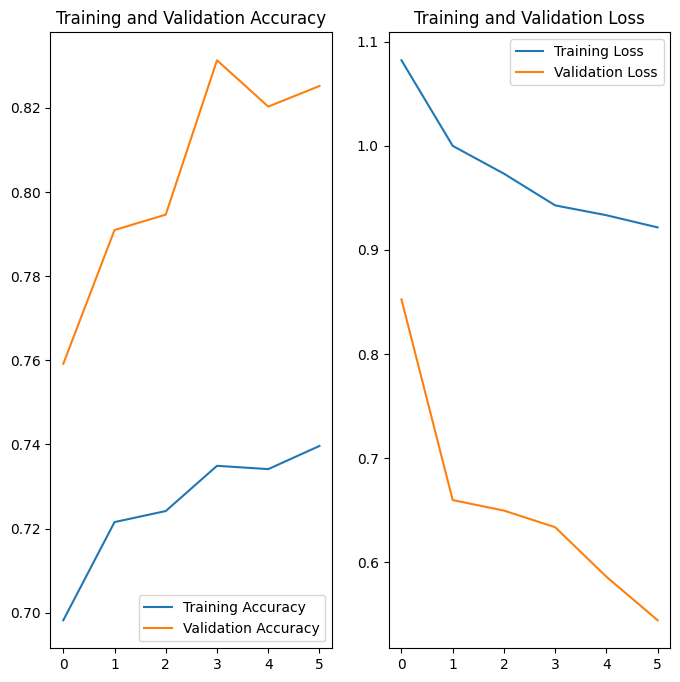

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
image_batch, label_batch = next(iter(test_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

1/1 [==============================] - 0s 496ms/step


In [19]:
# Print True Labels and Predicted Indices
print(predicted_ids)
print(label_batch)

[0 0 0 3 0 3 0 0 0 0 0 3 0 0 3 3 3 0 3 0 0 0 3 0 0 1 0 0 0 0 0 0]
[0 0 3 3 0 3 0 0 0 0 0 3 0 0 3 3 3 0 3 0 0 0 3 0 0 2 1 0 0 0 0 0]


In [24]:
class_names = np.array(dataset_info.features["objects"]["type"].names)
predicted_class_names = class_names[predicted_ids]
correct_class_names = class_names[label_batch]

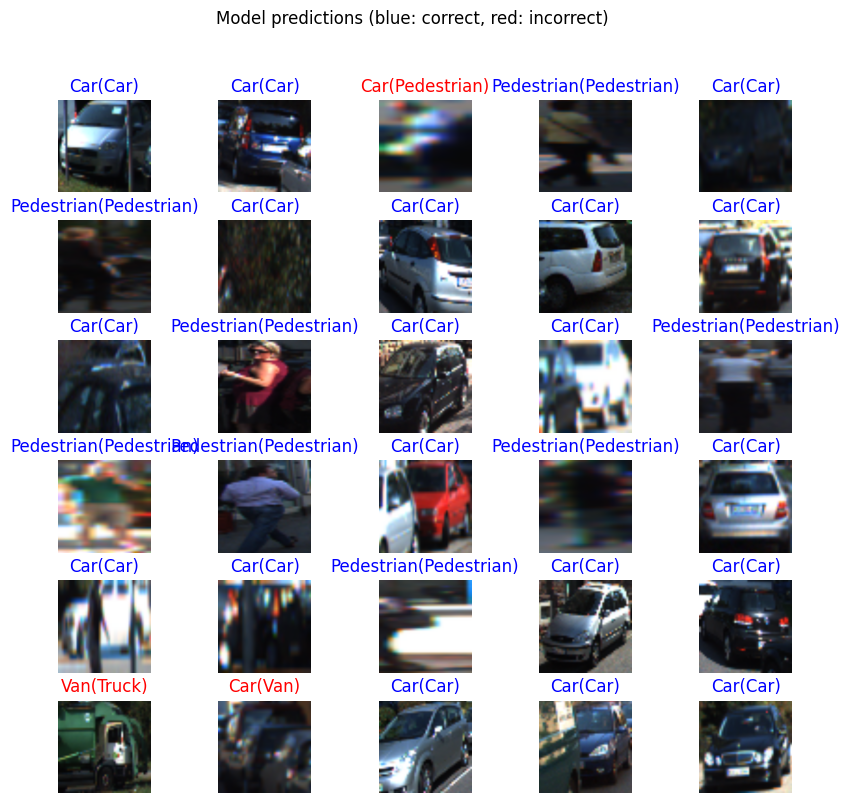

In [25]:
# Plot Model Predictions
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title() + '('+correct_class_names[n].title()+')', color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")